# A3: Frequency Domain Filtering
**CS6640: Image Processing**

**Author: Cade Parkison**

---

**Jupyter Notebook Settings:**

Make the output cells to use compact formatting:

In [67]:
format compact

Plot images in the notebook, as opposed to `%plot native` which uses matlab gui window to plot

In [2]:
%plot inline

In [36]:
%plot native

---

**TODO:**

- Zero Padding
- refactor rings and angular to loop through each pixel first, calcultaing angle or distance, and then looping through segments 

---
**Test Image:**

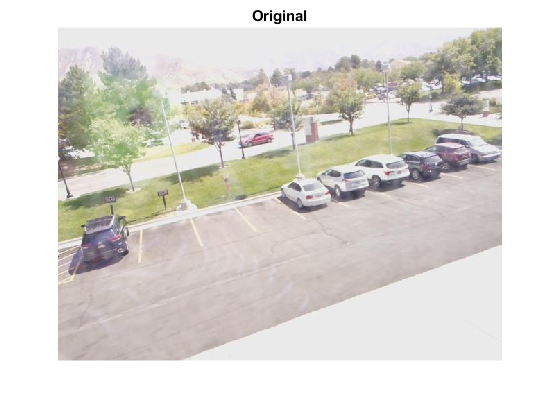

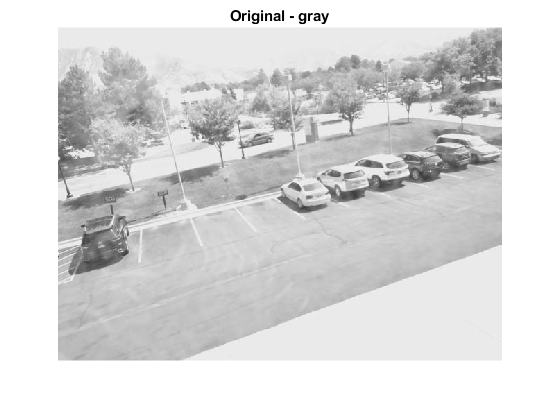

In [1]:
im_rgb = imread('im2.jpg');
im = rgb2gray(im_rgb);
figure(1);imshow(im); title('Original - gray');
figure(2);imshow(im_rgb); title('Original');

---

## Problem 1

Develop a texture feature analysis tool based on the 2D FFT power spectrum. For every 5x5 region in the image, compute the 2D FFT, compute the power spectrum, and use that as a 25-element feature vector. Produce a texture feature array, M*N by 25, and then use kmeans as in A2 to explore the usefulness of this for semantic region analysis (based on texture) in our videos.


#### Functions

In [ ]:
%%file CS6640_FFT_texture.m

function  T = CS6640_FFT_texture(im)
% CS6640_FFT_texture - compute FFT texture parameters
% On input:
%     im (MxN array): input image
% On output:
%     T (M*Nx25 array): texture parameters
%       each texture parameter is a column vector in T
% Call:
%     T = CS6640_FFT_texture(im);
% Author:
%     Cade Parkison
%     UU
%     Fall 2018
%

[M,N] = size(im);
T = zeros(M,N, 25);
window = 5;

for i=3:M-2
    for j=3:N-2
        % get 5x5 window surrounding (i,j)
        w = im(i-2:i+2, j-2:j+2);
        % take FFT of window
        F = fft2(w);
        % get power spectrum of F 
        ps = F.*conj(F);
        % Fill in T at (x,y,t) where t is the texture parameter 1:25
        T(i,j,1:25) = ps(:);
    end
end

% reshape T to (480*640 x 25)
T = reshape(T, M*N, 25);

---
#### Testing

In [ ]:
clear all;close all;clc

Calculate Texture parameters and pass them to k-means:

In [25]:
T = CS6640_FFT_texture(im);
[cidx,ctrs] = kmeans(T,7);

Plot the combo images for each k-means parameter:

In [38]:
figure(1);combo(mat2gray(im),(reshape(cidx==1,480,640)));title('K=1');

In [39]:
figure(2);combo(mat2gray(im),(reshape(cidx==2,480,640)));title('K=2');

In [40]:
figure(3);combo(mat2gray(im),(reshape(cidx==3,480,640)));title('K=3');

In [41]:
figure(4);combo(mat2gray(im),(reshape(cidx==4,480,640)));title('K=4');

In [42]:
figure(5);combo(mat2gray(im),(reshape(cidx==5,480,640)));title('K=5');

In [43]:
figure(6);combo(mat2gray(im),(reshape(cidx==6,480,640)));title('K=6');

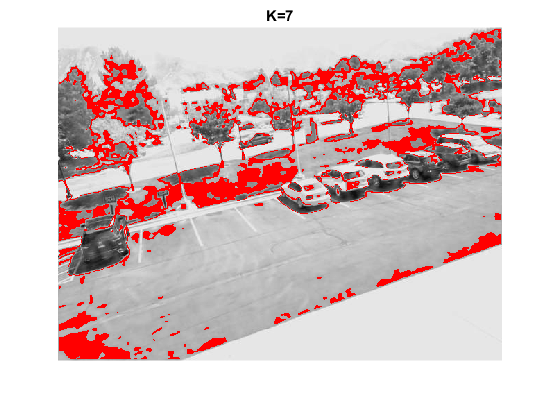

In [32]:
figure(7);combo(mat2gray(im),(reshape(cidx==7,480,640)));title('K=7');

In [33]:
%figure(8);combo(mat2gray(im),(reshape(cidx==8,480,640)));title('K=8');

In [34]:
%figure(9);combo(mat2gray(im),(reshape(cidx==9,480,640)));title('K=9');

In [35]:
figure(10);combo(mat2gray(rgb2gray(im)),(reshape(cidx==7|cidx==3,480,640)));

---
## Problem 2

Develop another FFT texture analysis approach based on radial segments
of the power spectrum. A radial feature is defined by a radius pair:

$$ f_{r_1,r_2} = \sum \sum {| F(u, v) |}^2 $$

where $ {r_1}^2 ≤ u^2 + v^2 < {r_2}^2 $. 
Suppose there are 10 such pairs, specified by 10 radii; i.e.:
$ R = \{0, r_1, r_2, . . . , r_10\} $ Produce a texture feature array, M*N by 10, and then use kmeans
as in A2 to explore the usefulness of this for semantic region analysis (based on texture) in
our videos.

#### Functions

In [ ]:
%%file CS6640_rings.m

function rings = CS6640_rings
%  CS6640_rings - computes cell array of linear indices of each ring to be used with the FFT_radial function
%
% On output:
%     rings (cell array) - Structure holding the (x,y) index pairs of each ring
% Call:
%     rings = CS6640_rings;
% Author:
%     Cade Parkison
%     UU
%     Fall 2018
%

rings = {};
% center
xc = 10; yc = 10;

for r=0:9;
    ring = [];
    rmin = r;
    rmax = r+1;
    for i=1:19
        for j=1:19
            % L-p norm from pixel to center of window
            p = 10;
            x = (xc-i)^p + (yc-j)^p;
            d = nthroot(x, p);
            if d >= rmin
                if d < rmax
                    % find linear index for corresponding (i,j) in the 19x19 matrix
                    ind = sub2ind([19,19], i, j);
                    ring = [ind; ring];
                end
            end
        end
    end
    rings{r+1} = ring; 
end
end

In [ ]:
%%file CS6640_FFT_radial.m

function  T = CS6640_FFT_radial(im)
%  CS6640_FFT_radial - compute FFT radial texture parameters
% On input:
%     im (MxN array): input image
% On output:
%     T (M*Nx10 array): texture parameters
%       each texture parameter is a column vector in T
% Call:
%     T = CS6640_FFT_radial(im);
% Author:
%     Cade Parkison
%     UU
%     Fall 2018
%

[M,N] = size(im);
T = zeros(M,N, 10);

% Cell array of length 10, each element containing list of (x,y) indices for each annulus
rings = CS6640_rings;

for i=10:M-9
    for j=10:N-9
        
        % get 19x19 window surrounding (i,j)
        w = im(i-9:i+9, j-9:j+9);
        % take FFT of window
        F = fft2(w);
        % get power spectrum of F 
        ps = F.*conj(F);
        % Compute Radial segments of ps for each annulus
        ps_radial = zeros(1,10);
        for r=1:10
            ps_r = ps(rings{r});
            % sum square of ps_r
            ps_radial(r) = sum(ps_r.^2);
        end
        
        % Fill in T at (x,y,t) where t is the texture parameter 1:10
        T(i,j,1:10) = ps_radial(:);
    end
end

% reshape T to (480*640 x 10)
T = reshape(T, M*N, 10);

---
#### Testing

In [ ]:
clear all;close all;clc;

Calculate Texture parameters and pass them to k-means:

In [ ]:
T_radial = CS6640_FFT_radial(im);
[cidx_r,ctrs_r] = kmeans(T_radial,7);

Plot the combo images for each k-means parameter:

In [ ]:
figure(1);combo(mat2gray(im),(reshape(cidx_r==1,480,640)));title('K=1');

In [ ]:
figure(2);combo(mat2gray(im),(reshape(cidx_r==2,480,640)));title('K=2');

In [ ]:
figure(3);combo(mat2gray(im),(reshape(cidx_r==3,480,640)));title('K=3');

In [ ]:
figure(4);combo(mat2gray(im),(reshape(cidx_r==4,480,640)));title('K=4');

In [ ]:
figure(5);combo(mat2gray(im),(reshape(cidx_r==5,480,640)));title('K=5');

In [ ]:
figure(6);combo(mat2gray(im),(reshape(cidx_r==6,480,640)));title('K=6');

In [ ]:
figure(7);combo(mat2gray(im),(reshape(cidx_r==7,480,640)));title('K=7');

In [ ]:
%figure(8);combo(mat2gray(im),(reshape(cidx_r==8,480,640)));title('K=8');

In [ ]:
%figure(9);combo(mat2gray(im),(reshape(cidx_r==9,480,640)));title('K=9');

In [ ]:
%figure(10);combo(mat2gray(im),(reshape(cidx_r==1|cidx_r==4,480,640)));

---
## Problem 3

Develop another FFT texture analysis approach based on angular segments of the power spectrum. An angular feature is defined by a angle pair:

$$ f_{θ_1,θ_2} = \sum \sum {| F(u, v) |}^2 $$

where $θ_1 ≤ tan^{−1}(v, u) < θ_2$, and $u^2 + v^2 < L^2$
for some appropriate L. Suppose there
are 8 such segments, specified by 9 angles; i.e.: $A = \{0, ∆, 2∆, . . . , 8∆\}$, where $∆ = 45$ degrees. Produce a texture feature array, M*N by 8 (where these cover ∆θ between the following angles: $\{0, 45, 90, 135, 180, 225, 270, 315, 360\}$, and then use kmeans as in A2 to explore the usefulness of this for semantic region analysis (based on texture) in our videos.

#### Functions

**TODO:**

- Develop function to get pixel indices of each angular segment

In [4]:
%%file CS6640_angular.m

function segments = CS6640_angular(w)
%  CS6640_rings - computes cell array of linear indices of each angular segment to be used with the FFT_angular function
%
% On Input:
%    w (integer) - window size in pixels, must be odd
% On output:
%     segments (cell array) - Structure holding the (x,y) index pairs of each angular segment
% Call:
%     segments = CS6640_angular;
% Author:
%     Cade Parkison
%     UU
%     Fall 2018
%

segments = {};

% center of (w x w) window - (xc,yc)
xc = idivide(w, int32(2), 'ceil');
yc = xc;

for a=0:7;
    seg = [];
    % calculate min and max angles (degrees) for each angular segment
    amin = a*45 - 180;
    amax = (a+1)*45 -180;
    for i=1:w
        for j=1:w
            % Calculate angle from center of window to each window pixel
            dx = double(i - xc);
            dy = double(j - yc);
            theta = atan2d(dy,dx);
            if theta >= amin
                if theta < amax
                    % find linear index for corresponding (i,j) in the wxw window matrix
                    ind = sub2ind([w,w], i, j);
                    seg = [ind; seg];
                end
            end
        end
    end
    segments{a+1} = seg; 
end
end

Created file 'C:\Users\cadep\School\CS_6640\A3\CS6640_angular.m'.


In [ ]:
%%file CS6640_FFT_angular.m

function  T = CS6640_FFT_angular(im)
%  CS6640_FFT_angular - compute FFT angular texture parameters
% On input:
%     im (MxN array): input image
% On output:
%     T (M*Nx8 array): texture parameters
%       each texture parameter is a column vector in T
% Call:
%     T = CS6640_FFT_angular(im);
% Author:
%     Cade Parkison
%     UU
%     Fall 2018
%

[M,N] = size(im);
T = zeros(M,N, 8);

% Window size W (must be odd number)
W = 19;
% half window
h = double(idivide(W, int32(2), 'floor'));

% Cell array of length 8, each element containing list of (x,y) indices for each angulur segment
segments = CS6640_angular(W);

for i=h+1:M-h
    for j=h+1:N-h
        
        % get w x w window surrounding (i,j)
        window = im(i-h:i+h, j-h:j+h);
        % take FFT of window
        F = fft2(window);
        % get power spectrum of F 
        ps = F.*conj(F);
        % Compute angular segments of ps
        ps_angular = zeros(1,8);
        for s=1:8
            ps_a = ps(segments{s});
            % sum square of ps_a
            ps_angular(s) = sum(ps_a.^2);
        end
        
        % Fill in T at (x,y,t) where t is the texture parameter 1:10
        T(i,j,1:8) = ps_angular(:);
    end
end

% reshape T to (480*640 x 8)
T = reshape(T, M*N, 8);

---
#### Testing

In [ ]:
clear all;close all;clc;

Calculate Texture parameters and pass them to k-means:

In [ ]:
T_angular= CS6640_FFT_angular(im);
[cidx_a,ctrs_a] = kmeans(T_angular,7);

Plot the combo images for each k-means parameter:

In [ ]:
figure(1);combo(mat2gray(im),(reshape(cidx_a==1,480,640)));title('K=1');

In [ ]:
figure(2);combo(mat2gray(im),(reshape(cidx_a==2,480,640)));title('K=2');

In [ ]:
figure(3);combo(mat2gray(im),(reshape(cidx_a==3,480,640)));title('K=3');

In [ ]:
figure(4);combo(mat2gray(im),(reshape(cidx_a==4,480,640)));title('K=4');

In [ ]:
figure(5);combo(mat2gray(im),(reshape(cidx_a==5,480,640)));title('K=5');

In [ ]:
figure(6);combo(mat2gray(im),(reshape(cidx_a==6,480,640)));title('K=6');

In [ ]:
figure(7);combo(mat2gray(im),(reshape(cidx_a==7,480,640)));title('K=7');

In [ ]:
figure(8);combo(mat2gray(im),(reshape(cidx_a==8,480,640)));title('K=8');

In [ ]:
figure(9);combo(mat2gray(im),(reshape(cidx_a==9,480,640)));title('K=9');

In [ ]:
figure(10);combo(mat2gray(im),(reshape(cidx_a==5|cidx_a==7,480,640)));title('K=5 & K=7');

---
## Problem 4

Develop a Fourier shape descriptor function as described in the Zahn and Roskies paper (in ’lectures’ link from class web page, weeks5-6). I.e., given a shape as a set of connected boundary points:

$$ P = \{(x_i, y_i)\} $$

where i = 1 : N, of a shape (going clockwise), then the angle at each point is computed as:

$$ θ(t) = atan2(y(t + w) − y(t), x(t + w) − x(t)) $$

where w is a distance along the curve. θ is better produced by taking the previous direction,
and adding to it the amount of change in angle to get the current angle. Then produce the
function:

$$ φ(t) = (θ(t) − θ(0))mod2π $$

and

$$ ψ(a) = (φ(\frac{La}{2π}) + a)modπ $$

where ψ is computed over the interval [0, 2π]. Take the FFT of ψ, and if there are 2p Fourier coefficients, use the power of coefficients 2 to p as the shape descriptor (a vector).


#### Functions

In [83]:
%%file CS6640_gen_H.m

function H = CS6640_gen_H
% CS6640_gen_H - generate points on the boundary of letter H
% On input:
%     N/A
% On output:
%     H (43x2 array): x,y locations of boundary
% Call:
%     H = CS6640_gen_H;
% Author:
%     T. Henderson
%     UU
%     Fall 2018
%

H = [2,10; 3,10; 4,10; 4,9; 4,8; 4,7; 5,7; 6,7; 7,7; 7,8; 7,9; 7,10;...
    8,10; 9,10; 9,9; 9,8; 9,7;, 9,6; 9,5; 9,4; 9,3; 9,2; 8,2; 7,2; ...
    7,3; 7,4; 7,5; 6,5; 5,5; 4,5; 4,4; 4,3; 4,2; 3,2; 2,2; 2,3; 2,4;...
    2,5; 2,6; 2,7; 2,8; 2,9;2,10];

Created file 'C:\Users\cadep\School\CS_6640\A3\CS6640_gen_H.m'.


In [49]:
%%file CS6640_gen_O

function C = CS6640_gen_O
% CS6640_gen_H - generate points on the boundary of letter H
% On input:
%     N/A
% On output:
%     H (43x2 array): x,y locations of boundary
% Call:
%     H = CS6640_gen_H;
% Author:
%     T. Henderson
%     UU
%     Fall 2018
%

C = [6,17; 7, 17; 8,17; 9,17; 10,17; 11,17; 12,17; 13,16; 14,15;...
    15,14; 16,13; 17,12; 17,11; 17,10; 17,9; 17,8; 17,7; 16,6; ...
    15,5; 14,4; 13,3; 13,2; 12,2; 11,2; 10,2; 9,2; 8,2; 7,2; 6,3;...
    5,4; 4,5; 3,6; 2,6; 2,7; 2,8; 2,9; 2,10; 2,11; 2,12; 3,13; ...
    4,14; 5,15; 6,16; 7,17];


Created file 'C:\Users\cadep\School\CS_6640\A3\CS6640_gen_O'.


In [ ]:
%%file CS6640_FFT_shape.m

function  X = CS6640_FFT_shape(Z,w)
%  CS6640_FFT_shape - compute Fourier shape descriptors for a curve
% On input:
%     Z (Nx2 array): input curve (should be closed)
%     w (int): distance along curve to determine angles
% On output:
%     X ((N/2-1)x1 vector): the Fourier coefficients for the curve
% Call:
%     X = CS6640_FFT_shape(curve,2);
% Author:
%     Cade Parkison
%     UU
%     Fall 2018
%



#### Testing

In [101]:
clear all;close all;clc;

In [102]:
H = CS6640_gen_H;
O = CS6640_gen_O;
size(O), size(H)

ans =
    44     2
ans =
    43     2



In [103]:
Z = H;

In [104]:
s = size(Z);
N = s(1);
theta = zeros(1,N);

for i=1:N-1
    p1 = Z(i,:);
    p2 = Z(i+1,:);
    t = atan2((p2(2)-p1(2)),(p2(1)-p1(1)));
    theta(i) = t;
end

phi = zeros(1,N);
for i=1:N
    phi_rad = theta(i) - theta(1);
    % wrap to interval [0, 2*pi]
    phi(i) = phi_rad - 2*pi*floor(phi_rad/(2*pi));
end

L= N;
psi = zeros(1,N);
for i=1:N
    
end

In [106]:
theta

theta =
  Columns 1 through 16
         0         0   -1.5708   -1.5708   -1.5708         0         0         0    1.5708    1.5708    1.5708         0         0   -1.5708   -1.5708   -1.5708
  Columns 17 through 32
   -1.5708   -1.5708   -1.5708   -1.5708   -1.5708    3.1416    3.1416    1.5708    1.5708    1.5708    3.1416    3.1416    3.1416   -1.5708   -1.5708   -1.5708
  Columns 33 through 43
    3.1416    3.1416    1.5708    1.5708    1.5708    1.5708    1.5708    1.5708    1.5708    1.5708         0



In [108]:
rad2deg(4.7124),rad2deg(-1.5708)

ans =
  270.0006
ans =
  -90.0002



In [105]:
phi

phi =
  Columns 1 through 16
         0         0    4.7124    4.7124    4.7124         0         0         0    1.5708    1.5708    1.5708         0         0    4.7124    4.7124    4.7124
  Columns 17 through 32
    4.7124    4.7124    4.7124    4.7124    4.7124    3.1416    3.1416    1.5708    1.5708    1.5708    3.1416    3.1416    3.1416    4.7124    4.7124    4.7124
  Columns 33 through 43
    3.1416    3.1416    1.5708    1.5708    1.5708    1.5708    1.5708    1.5708    1.5708    1.5708         0



In [95]:
angle = 2.5*pi
angle = angle - 2*pi*floor(angle/(2*pi))

angle =
    7.8540
angle =
    1.5708



In [87]:
?mod

 MOD    Modulus after division.
    MOD(x,y) returns x - floor(x./y).*y if y ~= 0, carefully computed to
    avoid rounding error. If y is not an integer and the quotient x./y is
    within roundoff error of an integer, then n is that integer. The inputs
    x and y must be real and have compatible sizes. In the simplest cases,
    they can be the same size or one can be a scalar. Two inputs have
    compatible sizes if, for every dimension, the dimension sizes of the
    inputs are either the same or one of them is 1.
 
    The statement "x and y are congruent mod m" means mod(x,m) == mod(y,m).
 
    By convention:
       MOD(x,0) is x.
       MOD(x,x) is 0.
       MOD(x,y), for x~=y and y~=0, has the same sign as y.
 
    Note: REM(x,y), for x~=y and y~=0, has the same sign as x.
    MOD(x,y) and REM(x,y) are equal if x and y have the same sign, but
    differ by y if x and y have different signs.
 
    See also REM.

    Reference page in Doc Center
       doc mod

    Other functio

In [81]:
angles

angles =
  Columns 1 through 27
     0     0   -90   -90   -90     0     0     0    90    90    90     0     0   -90   -90   -90   -90   -90   -90   -90   -90   180   180    90    90    90   180
  Columns 28 through 42
   180   180   -90   -90   -90   180   180    90    90    90    90    90    90    90    90



In [82]:
theta

theta =
  Columns 1 through 27
   -90     0   -90     0     0    90     0     0    90     0     0   -90     0   -90     0     0     0     0     0     0     0   270     0   -90     0     0    90
  Columns 28 through 42
     0     0  -270     0     0   270     0   -90     0     0     0     0     0     0     0



In [79]:
theta(theta>180) = theta(theta>180) - 180

theta =
  Columns 1 through 27
   -90     0   -90     0     0    90     0     0    90     0     0   -90     0   -90     0     0     0     0     0     0     0    90     0   -90     0     0    90
  Columns 28 through 42
     0     0  -270     0     0    90     0   -90     0     0     0     0     0     0     0



In [40]:
p_start = Z(1,:)
p_end = Z(N,:)
a = atan2((p_start(2)-p_end(2)),(p_start(1)-p_end(1)))


p_start =

     2    10


p_end =

     2    10


a =

     0




In [46]:
O(1,:)
O(44,:)
size(O)


ans =

     6    17


ans =

     7    17


ans =

    44     2




In [12]:
theta = zeros(1,10);
theta(1)= 1


theta =

     1     0     0     0     0     0     0     0     0     0




In [20]:
p1 = Z(3,:)
p2 = Z(4,:)


p1 =

     4    10


p2 =

     4     9




In [22]:
(p2(2)-p1(2)),(p2(1)-p1(1))


ans =

    -1


ans =

     0




In [38]:
1 ~= 2


ans =

  logical

   1




In [24]:
t = atan2((p2(2)-p1(2)),(p2(1)-p1(1)))


t =

   -1.5708




In [13]:
?atan2

 ATAN2  Four quadrant inverse tangent.
    ATAN2(Y,X) is the four quadrant arctangent of the elements of X and Y
    such that -pi <= ATAN2(Y,X) <= pi. X and Y must have compatible sizes.
    In the simplest cases, they can be the same size or one can be a
    scalar. Two inputs have compatible sizes if, for every dimension, the
    dimension sizes of the inputs are either the same or one of them is 1.
 
    See also ATAN, ATAN2D.

    Reference page in Doc Center
       doc atan2

    Other functions named atan2

       sym/atan2



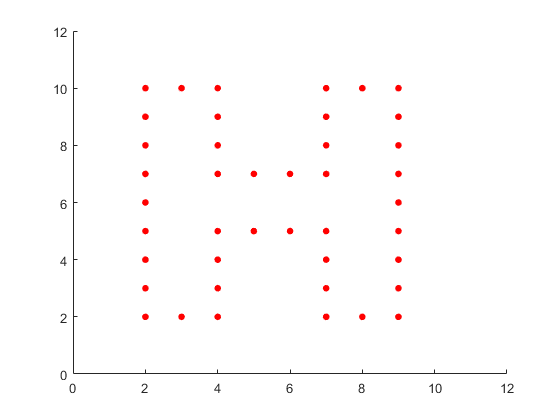

In [18]:
scatter(H(:,1), H(:,2), 25, 'red', 'filled')
xlim([0 12]);
ylim([0 12]);

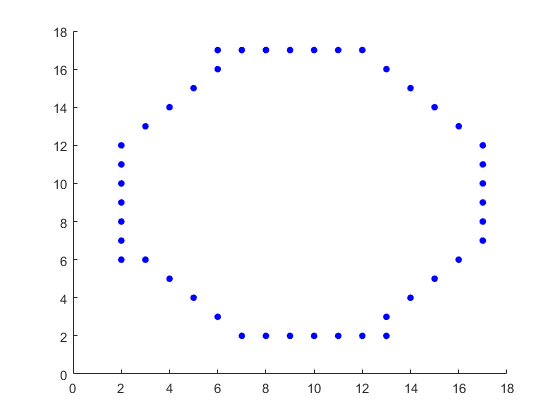

In [23]:
scatter(O(:,1), O(:,2), 25, 'blue', 'filled')
xlim([0 18]);
ylim([0 18]);